## Part I: Case Study Conclusions

## I. Case study: relation between mRNA and protein levels

### In previous classes ...

- we have been working on a case study from Biology aiming to study the relation between mRNA and protein levels

- the Central Dogma of Biology: protein levels should be highly related to mRNA levels

- however, data show weak associations between these features for most genes

### Wilhelm's Claim (2014)

Using the median ratio of protein to mRNA levels per gene as a proxy for translation rates, our data show that [...] ***it now becomes possible to predict protein abundance in any given tissue with good accuracy from the measured mRNA abundance***

<center>
<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/nature_res.png?raw=true" style="width:700px;"/>
</center>

## Today ...

<font color="blue"> **How did the authors find a strong correlation between observed and predicted protein levels?** </font>

**Review on performance measures**



## Review: Model Evaluation

### <font color=blue> Is this a **good** model??
    
This is a ***very general question***!! which we can (should) break down into more specific questions
    
    
**Intuitively**: if the model is good, $\hat{y}_i$ should be close to $y_i$


## Evaluation metrics

Many metrics used to evaluate LR measure how far $y$ is from $\hat{y}$:

(note $p$ is number of parameters in a linear model)

- **Residuals Sum of Squares**: RSS = $\sum_{i=1}^n(y_i - \hat{y}_i)^2$

- **Residuals Standard Error**: RSE = $\sqrt{\frac{1}{n-p-1} \text{RSS}}$

- **Mean Squared Error**: MSE = $\frac{1}{n} RSS$

- **Coefficient of Determination**, $R^2 = 1 - \frac{RSS}{TSS}$

- **Adjusted $R^2$**, $R^2 = 1 - \frac{RSS/(n-p)}{TSS/(n-1)}$

> it is a common measure of goodness of fit: how well does the model fit the *training* data? 

> penalizes the RSS by the size of the model so it can be used to compare models of different sizes

- **The F-statistic**: $F=\frac{(RSS_r - RSS_f)/k}{RSS_f/(n-p)}$

> it also compares $y$ vs $\hat{y}$ from the *training* set using the RSS

> the form of the statistic is such that (asymptotically) follows an $F$ distribution, so it can be used to *test* if *multiple* coefficients are *simultaneously equal to zero.

## Application in the mRNA-protein case study

In [4]:
library(tidyverse)
library(repr)
options(repr.plot.width=7, repr.plot.height=4)
library(ggplot2)
library(broom)
library(gridExtra)
library(GGally)
library(latex2exp)

# Read and take a look at the data.
dat_bio <- read.csv("data/nature_dat.csv", row.names = 1, stringsAsFactors=TRUE)

In [11]:
rsq_ls <- dat_bio %>%  group_by(gene) %>%
  do(glance(lm(prot ~ mrna, data = .))) %>% 
  # drop_na(sigma) %>% 
  select(gene, r.squared)


In [12]:
hist_ls_r2 <- ggplot(rsq_ls, aes(x=r.squared)) + geom_histogram(color="navy") + 
  theme_bw(16) + xlab("Rsq per gene for LS-estimated models") + ylab("Count") +
  geom_vline(xintercept=median(rsq_ls$r.squared, na.rm=T),color="red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


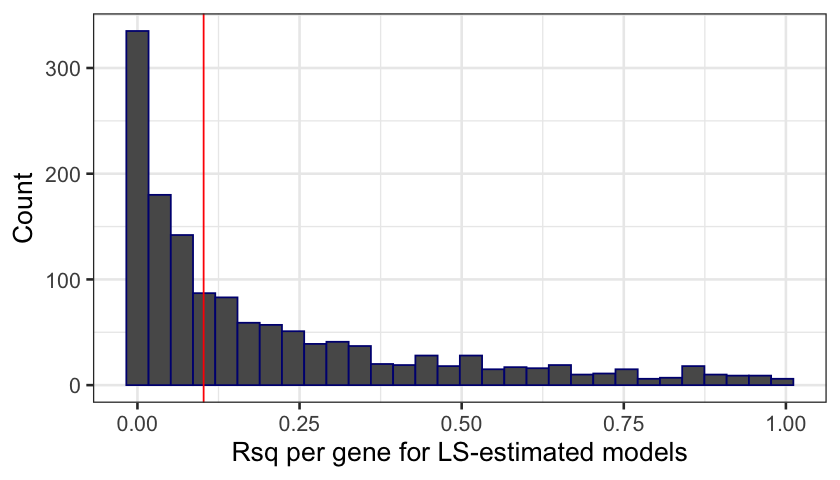

In [13]:
hist_ls_r2

**These results suggest that**:

- the quality of the proposed models vary greatly across genes

- for some genes, a LS-SLR with mRNA as input variable is a good model to fit the data

- however, for the *majority* of the genes, a LS-SLR does not fit the data well

However, the conclusions of the Nature's paper are different. 

**Which measure was used in the Nature's article to get opposite conclusions??**

#### Which measure was used in the Nature's article??

Their main goal was to *predict* but they supported their conclusions using the correlation between the observed protein levels ($y_i$) and the predicted ones ($\hat{y}_i$) from the <font color=red> *training* set!!    
    
> This was not the main issue of the analysis. Similar results are obtained using a test set (from cross-validation)
    
<center>
<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/nature_res.png?raw=true" style="width:700px;"/>
</center>

Let's try to understand point-by-point what has been done:

- the paper reports the correlation between the observed and the predicted protein for *all* genes *per* tissue.

They also compared $y_i$ versus $\hat{y}_i$. **But, is their correlation a good measure??**

The correlation is a measurement commonly used to check the proximity of 2 variables: 

> if $y_i$ is close to $\hat{y}_i$, then in a scatter plot, points are close to the 45 degree line and their correlation is large. 

**True, but** it can be confounded if we mix predicted values $\hat{y}_i$ from different models!!

#### Ignoring gene-effect: looking at salivary gland for all genes

Note that the correlation can be large, even when some points (genes) are *far* from the diagonal!! The correlation is driven by the large dynamic range in protein values

In [14]:
#adding predictions to data 

#median-ratios
rr <- dat_bio  %>% mutate(ratio=prot/mrna)  %>% group_by(gene)  %>% 
    summarize(ratio_g=median(ratio,na.rm =  TRUE),se_ratio=1.25*sd(ratio,na.rm=TRUE)/sqrt(length(ratio)))

dat_ratio <- dat_bio %>% full_join(rr, by= "gene") %>% mutate(pred_ratio=mrna*ratio_g)


In [15]:
dat_sal <- dat_ratio  %>% filter(tissue=="salivary.gland")
r_sal <- dat_sal  %>% summarize(r=cor(prot,pred_ratio,use="complete.obs",method="spearman"))

In [16]:
conf_plot_sg <- ggplot(dat_sal,aes(log(prot),log(pred_ratio)))+
           geom_point() +
            geom_abline(intercept=0,slope=1,color="red",linetype="dashed") +
            annotate(geom="text", x=-15, y=-5, label="cor=0.91", color="red")+
            annotate(geom="text", x=-15, y=-4, label="salivary.gland", color="red")+
            stat_ellipse(level=0.99,size=2,color="red")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


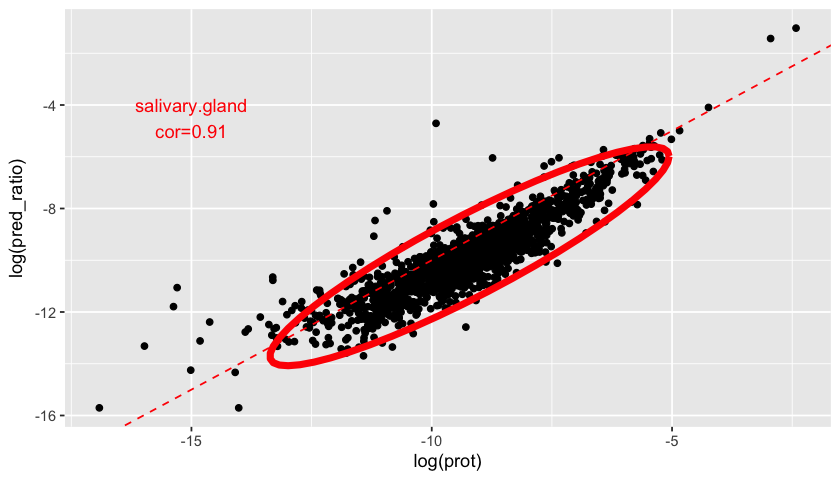

In [17]:
conf_plot_sg

### Confounding 

#### but the story *per gene* is different!

A simpler plot with less genes shows that the relation between the observed and the predicted ($y$ and $\hat{y}$, respectively) protein levels varies much by gene!!
 
 - for some genes the points are tighly around the line
 - for others, they are very disperse indicating that the predicted values are not similar to the observed ones

In [18]:
dg1<-dat_ratio %>% filter(gene =="ENSG00000135655")
dg2<-dat_ratio %>% filter(gene =="ENSG00000105953")
dg3<-dat_ratio %>% filter(gene =="ENSG00000116791")
dg4<-dat_ratio %>% filter(gene =="ENSG00000205629")

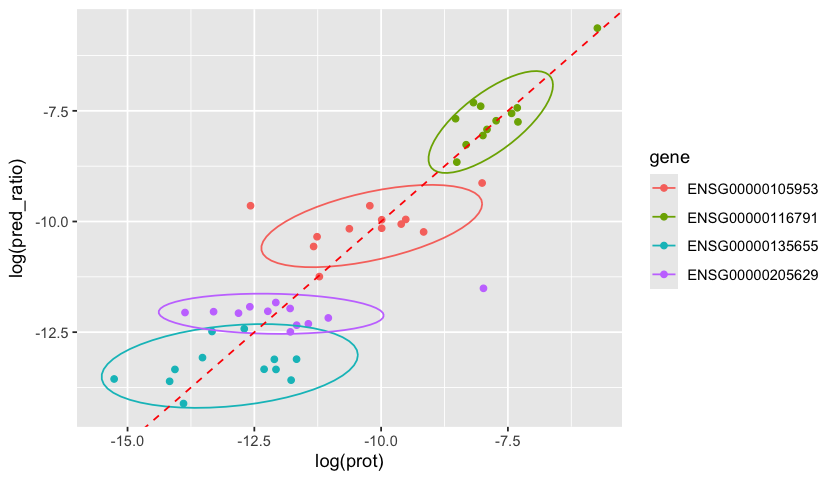

In [19]:
dat_plot <-rbind(dg1,dg2,dg3,dg4)
dat_sal <- dat_plot  %>% filter(tissue=="salivary.gland")
conf_plot_g <- ggplot(dat_plot,aes(log(prot),log(pred_ratio),color=gene))+
            geom_point() + stat_ellipse(level=0.9)+
            geom_abline(intercept=0,slope=1,color="red",linetype="dashed")
#+
#            geom_point(aes(log(dat_sal$prot),log(dat_sal$pred_ratio)),shape=5,size=3)
conf_plot_g

#### The MSE

In our response we compared the training (and test) MSE of their estimated model versus that of a null model (intercept-only, without mRNA)

With training set data, for many genes (about half) the proposed model does not predict better than the null. Similar results were found for the test MSE.

<center>
<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/mse.png?raw=true" style="width:400px;"/>
</center>

#### A correlation analysis *per-tissue* ignores the gene-to-gene variation. Thus, their analysis is *confounded*!! 

In this analysis, the categorical variable, `gene`, is the confounding factor!

- `gene` is related with protein values (response) *and* with the predicted values (input in the correlation analysis)

> Note that the variable `gene` was not implicitly used in the paper. Gene-specific slopes can be obtained with a model *with* interactions instead of different gene-specific models. While estimates are equivalent (remember exercise in tutorial_03), SE are not

## <font color=red> 1.4 Conclusion for Part I
    
#### It is important that you understand: 

- what you are computing
    
- which set you are using (training vs test)
    
- for what purpose     